# Sistemas de recomendación

¿Qué vamos a hacer?
- Explorar el planteamiento de los filtros colaborativos
- Crear un dataset para resolver por sistemas de recomendación
- Implementar una función de coste y descenso de gradiente
- Entrenar un modelo de recomendación por filtros colaborativos
- Realizar predicciones de recomendaciones
- Reentrenar el modelo incorporando nuevas valoraciones
- Recomendar ejemplos similares

In [1]:
# TODO: Usa esta celda para importar todas las librerías necesarias

import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

np.random.seed(42)

# Crear el dataset sintético

Vamos a crear un dataset sintético de nuevo, pero ésta vez enfocado a los sistemas de recomendación, con algunas diferencias frente a la regresión lineal:

- Las variables predictoras o independientes *X* (de tamaño (m, n + 1)) que representan las características de cada ejemplo,  **no son conocidas** de antemano.
- El vector $\Theta$ (*Theta*) es 2D (de tamaño ($n_u$, n + 1)), puesto que ahora representa los pesos o coeficientes de las características para cada usuario. De nuevo, no es conocido de antemano.
- El vector *Y* es 2D (de tamaño (m, $n_u$)), puesto que ahora representa la valoración para cada ejemplo de cada usuario.
- El vector *Y* contendrá tanto las valoraciones "reales" que ha emitido cada usuario para cada película que ha valorado, como, al final del entrenamiento, una predicción de sus valoraciones para recomendarle una película u otra.
- *R* será una matriz "máscara" sobre *Y*, utilizada para indicar qué valoraciones de *Y* son las reales, emitidas por un usuario y por tanto sólo aquellas a tener en cuenta para entrenar el modelo, y cuáles son sólo predicciones.

Un ejemplo habitual son las recomendaciones de películas en un portal de streaming de video.
En este caso, un dataset tendría estas características, p. ej.:
- *m*: Nº de películas.
- *n*: Nº de características de cada película y de coeficientes de cada usuario.
- $n_u$: Nº de usuarios del portal.
- $n_rr$ y $n_r$: Porcentaje de valoraciones de cada película por cada usuario, y nº de valoraciones total, conocidos de antemano.
- *X*: Matriz 2D de características de cada película, tamaño (nº de películas, nº de características).
- $\Theta$: Matriz 2D de coeficientes de cada usuario para cada película, tamaño (nº de usuarios, nº de características).
- *Y*: Matrix 2D de valoraciones de cada usuario para cada película, tamaño (nº de usuarios, nº de películas).

Para tener a mano, os dejamos esta tabla rápida para consultar el tamaño de cada matriz:
- *X*(m, n + 1)
- $\Theta$($n_u$, n + 1)
- *Y*(m, $n_u$)

Para no complicar más la implementación, en este caso no preprocesaremos los datos, ya que deberíamos preprocesar *X* e *Y*, que además deberíamos pasar de una escala p. ej. 0-5 estrellas a [0, 1].

En la siguiente celda, sigue las instrucciones para generar un dataset con las características necesarias para poder resolverlo por un filtro colaborativo de sistemas de recomendación:

In [32]:
# TODO: Crea un dataset con las características necesarias para un sistema de recomendación
# Recuerda que puedes volver a esta celda y modificar el tamaño del dataset en cualquier momento

m = 10    # Nº de ejemplos
n = 4    # Nº de características de cada ejemplo/usuario
n_u = 3    # Nº de usuarios
n_rr = 0.5    # Porcentaje de valoraciones conocidas de antemano

X_verd = np.random.rand(m, n)
X_verd = np.insert(X_verd, 0, np.ones(m), axis=1)

Theta_verd = np.random.rand(n_u, n + 1)

Y_verd = np.matmul(X_verd, Theta_verd.T)

r = np.zeros((m, n_u))
count_r = round(n_rr * r.size)
while count_r:
    i = np.random.randint(m)
    j = np.random.randint(n_u)
    
    if not r[i,j]:
        r[i,j] = 1.
    
        count_r -= 1

n_r = np.count_nonzero(r)

y = np.multiply(Y_verd, r)

print('Tamaño de X(m, n+1), Theta(n_u, n+1) e Y(m, n_u) verdaderos:')
print(X_verd.shape, Theta_verd.shape, Y_verd.shape)
print('Tamaño de y y R conocidas:')
print(y.shape, r.shape)
print('Nº de elementos de R, o valoraciones conocidas:', n_r)

Tamaño de X(m, n+1), Theta(n_u, n+1) e Y(m, n_u) verdaderos:
(10, 5) (3, 5) (10, 3)
Tamaño de y y R conocidas:
(10, 3) (10, 3)
Nº de elementos de R, o valoraciones conocidas: 15


# Función de coste y descenso de gradiente

Vamos a implementar la función de coste regularizada y el descenso de gradiente regularizado para optimizarla y entrenar el modelo de ML.

Conceptualmente, en cuanto al entrenamiento del modelo por descenso de gradiente, vamos a seguir unos pasos diferentes a los de la regresión lineal.

Mientras que en la regresión lineal eran conocidas *Y* y *X*, y podíamos resolver iterativamente para $\Theta$, en esta ocasión *X* tampoco es conocida de antemano, ya que habitualmente es imposible en la práctica conocer o tener anotadas de antemano todas las características de todos los ejemplos o películas.

Además, mientras que sí tenemos algunas valoraciones por cada usuario de algunas películas, habitualmente tenemos un porcentaje bajo de todas las valoraciones de cada usuario para cada ejemplo, por lo que *Y* es otra matriz variable no completamente conocida de antemano, sino que la mayoría de sus campos estarán vacíos inicialmente.

Nuestro objetivo, en este caso, no será tanto resolver $\Theta$ como resolver *Y* para obtener todas las valoraciones predichas de cada usuario para cada ejemplo.

Por tanto, el algoritmo de entrenamiento será:
1. Recopilamos los ejemplos y las valoraciones en las matrices *X*, $\Theta$ e *Y*.
1. Marcamos las valoraciones conocidas en la matriz dispersa *R*.
1. Dadas *X* e *Y*, podemos predecir $\Theta$.
1. Dadas $\Theta$ e *Y*, podemos predecir *X*.
1. Estimamos de forma iterativa *X* y $\Theta$ en cada iteración hasta que el entrenamiento converja en un coste mínimo.
1. Cuando dispongamos de más valoraciones, reentrenamos el modelo añadiéndolas a *Y* y marcándolas en *R*.

En la siguiente celda, sigue las instrucciones para implementar la función de coste y gradient descent regularizados para un filtro colaborativo, siguiendo las siguientes fórmulas:

$$
\min\limits_{\theta^0, ..., \theta^{n_u} \\ x^0, ..., x^{n_m}}J(x^0, ..., x^{n_m}, \theta^0, ..., \theta^{n_u}) = \min\limits_{\theta^0, ..., \theta^{n_u} \\ x^0, ..., x^{n_m}} (\frac{1}{2} \sum\limits_{(i,j): r(i,j)=1} (\theta^{jT} x^i - y^{i,j})^2 \\ + \frac{\lambda}{2} \sum\limits_{i=0}^{n_m} \sum\limits_{k=0}^n (x^i_k)^2 + \frac{\lambda}{2} \sum\limits_{j=0}^{n_u} \sum\limits_{k=0}^n (\theta^j_k)^2) \\
x^i_k := x^i_k - \alpha (\sum\limits_{j: r(i,j) = 1} (\theta^{j T} x^i - y^{i,j})\theta^j_k + \lambda x^i_k); \\
\theta^j_k := \theta^j_k - \alpha (\sum\limits_{i: r(i,j) = 1} (\theta^{j T} x^i - y^{i,j}) x^i_k + \lambda \theta^j_k); j = 0 \rightarrow \lambda = 0
$$

In [29]:
# TODO: Implementa la función de coste y entrenamiento por descenso de gradiente para filtros colaborativos

def cost_function_collaborative_filtering_regularized(x, theta, y, r, lambda_=0.):
    j = np.sum(np.multiply(np.matmul(x, theta.T) - y, r)**2)
    
    x_reg = np.sum(x**2)
    theta_reg = np.sum(theta[:, 1:]**2)
    
    return 1/2 * (j + lambda_ * (x_reg + theta_reg))


def gradient_descent_collaborative_filtering_regularized(x, theta, y, r, lambda_=0., alpha=1e-3, n_iter=1e3, e=1e-3):
    n_iter = int(n_iter)
    
    j_hist = []
    j_hist.append(cost_function_collaborative_filtering_regularized(x, theta, y, r, lambda_))
    
    for l in range(n_iter):
        theta_grad = np.zeros(theta.shape)
        x_grad = np.zeros(x.shape)
                
        for j in range(n_u):
            theta_grad[j,:] = np.sum(np.matmul(np.multiply((np.matmul(x, theta[j,:].T) - y[:,j]), r[:,j]).T, x), axis=0)
            
            if j > 0:
                theta_grad[j,:] += lambda_ * theta[j,:]
            
        for i in range(m):
            x_grad[i,:] = np.sum(np.matmul(np.multiply((np.matmul(x[i,:], theta.T) - y[i,:]), r[i,:]), theta), axis=0) \
                + lambda_ * x[i,:]
        
        x -= alpha * x_grad
        theta -= alpha * theta_grad
        
        #print('\nValores de X y Theta actualizados:')
        #print(x)
        #print(theta)
        
        j_cost = cost_function_collaborative_filtering_regularized(x, theta, y, r, lambda_)
        j_hist.append(j_cost)
        
        if l > 0 and abs(j_cost - j_hist[-2]) <= e:
            print('Converge en iteración nº', l)
            
            break
    else:
        print('Nº máx. de iteraciones {} alcanzado'.format(n_iter))
        
    return j_hist, x, theta

# Entrenamiento del modelo

Una vez implementadas las funciones correspondientes, vamos a entrenar el modelo.

Para ello, completa la siguiente celda de código con pasos equivalentes a otros modelos de ejercicios previos.

In [30]:
# TODO: Entrena un modelo de sistema de recomendación por filtros colaborativos

x_init = np.random.rand(*X_verd.shape)
theta_init = np.random.rand(*Theta_verd.shape)

alpha = 1e-2
lambda_ = 0.
e = 1e-3
n_iter = 1e4
print('Hiperparámetros usados:')
print('Alpha:', alpha, 'Lambda:', lambda_, 'Error:', e, 'Nº iter', n_iter)

t0 = time.time()
j_hist, x, theta = gradient_descent_collaborative_filtering_regularized(x_init, theta_init, y, r, lambda_, alpha, n_iter, e)
print('Duración del entrenamiento:', time.time() - t0)

print('\nÚltimos 10 valores de la función de coste:')
print(j_hist[-10:])
print('\nError mínimo:')
print(min(j_hist))

Hiperparámetros usados:
Alpha: 0.01 Lambda: 0.0 Error: 0.001 Nº iter 10000.0
Converge en iteración nº 28
Duración del entrenamiento: 0.037807464599609375

Últimos 10 valores de la función de coste:
[0.07016343723411236, 0.06608165530140697, 0.06283730177998616, 0.060219277108107865, 0.05807462675057567, 0.05629205628656818, 0.05479011907397357, 0.053508778595484204, 0.05240339287901141, 0.05144042912363811]

Error mínimo:
0.05144042912363811


Como hemos hecho en ocasiones previas, representa gráficamente la evolución de la función de coste para comprobar que el entrenamiento del modelo ha sido correcto:

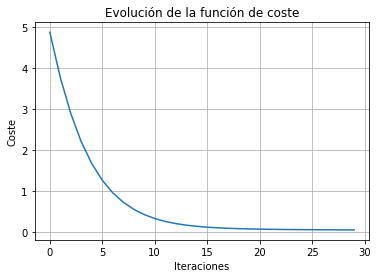

In [31]:
# TODO: Representa gráficamente la función de coste del entrenamiento del modelo vs el nº de iteraciones
plt.figure()

plt.plot(j_hist)

plt.title('Evolución de la función de coste')
plt.ylabel('Coste')
plt.xlabel('Iteraciones')
plt.grid()

plt.show()

# Realización de predicciones de recomendaciones

Una vez entrenado el modelo, podemos resolver la matriz de recomendaciones *Y*, que contiene como comentábamos tanto las valoraciones emitidas por los usuarios como una predicción de la valoración de cada usuario para cada ejemplo.

Recuerda que utilizábamos la matriz *R* para marcar con un "1" las valoraciones reales y con un "0" aquellas que se han predicho y no eran conocidas de antemano.

Para realizar una predicción y recomendar ejemplos a los usuarios (p. ej. películas), sigue las instrucciones para completar la siguiente celda de código:

In [51]:
# TODO: Realiza predicciones de ejemplos para los usuarios

# Muestra las valoraciones de la matriz Y
print('Valoraciones de Y:')
print(y[:10,:10] * r[:10, :10])    # Limita el nº de filas y columnas de Y si es necesario
# En el resultado, un valor de "0." indica un "0." en esa posición en R, o que esa valoración inicial no es conocida

# Calcula las predicciones obtenidas por el modelo a partir de X y Theta
y_pred = np.matmul(x, theta.T)

print('\nPredicciones de valoraciones:')
print(y_pred[:10,:10])

# Calcula los residuos de las predicciones
# Recuerda que los residuos son la diferencia en valores absolutos entre el valor real conocido y la predicción del modelo
# Recuerda calcularlos sólo cuando la valoración inicial es conocida, multiplicando los residuos por R
y_residuo = abs((y - y_pred) * r)

print('\nResiduos del modelo:')
print(y_residuo[:10,:10])

# Muestra las predicciones y valoraciones iniciales de un usuario dado
jj = 1    # Escoge el nº de usuario o índice entre 0 y n_u que quieras

print('\nValoraciones reales y predichas para el usuario nº {}:'.format(jj + 1))
print(y_pred[:,jj])

# Ordena los índices de los ejemplos que recomendaríamos a cada usuario en función de sus valoraciones
# Recuerda eliminar de la lista las valoraciones emitidas inicialmente por el usuario
# Para eliminarlas, puedes multiplicar las predicciones por (r[:,jj] == 0.)
# Para extraer los índices ordenados de un array puedes utilizar np.argsort()
# Para reordenar los índices de mayor a menor puedes utilizar np.flip()
print('\nValoraciones predichas para el usuario nº {}:'.format(jj + 1))
print(y_pred[:,jj] * (r[:,jj] == 0.))

y_pred_ord = np.flip(np.argsort(y_pred[:,jj] * (r[:,jj] == 0.)))

print('\nÍndices de los ejemplos a recomendar para el usuario {}, en función de las valoraciones predichas:'.format(jj + 1))
print(y_pred_ord)

Valoraciones de Y:
[[0.         1.22421551 1.48896241]
 [1.98267391 1.08731658 0.        ]
 [1.45124962 0.99292357 0.        ]
 [0.         0.         0.        ]
 [1.08939999 0.97593332 1.12387915]
 [0.         0.         1.46845616]
 [1.88292244 0.         1.95052465]
 [0.         1.31784062 1.43945296]
 [0.         0.         0.        ]
 [2.00632392 0.         0.        ]]

Predicciones de valoraciones:
[[1.75105062 1.9347148  1.67332584]
 [1.35349798 1.30383134 1.24993609]
 [1.58722164 1.89675962 1.53091253]
 [1.31325682 1.1113693  1.05003628]
 [1.68553026 2.1239005  1.6609967 ]
 [1.36599057 1.08280368 1.32859415]
 [1.43362307 2.03391901 1.29056604]
 [1.0134053  1.10384852 0.91446066]
 [1.27810789 1.68755683 1.28045073]
 [1.24428612 1.41880827 1.13610998]]

Residuos del modelo:
[[0.         0.71049928 0.18436343]
 [0.62917593 0.21651476 0.        ]
 [0.13597203 0.90383604 0.        ]
 [0.         0.         0.        ]
 [0.59613027 1.14796718 0.53711754]
 [0.         0.         0.

# Reentrenar incorporando nuevas valoraciones

Para reentrenar el modelo incorporando nuevas valoraciones de los usuarios, sólo hay que modificar la *Y* inicial con las nuevas valoraciones y marcar con un "1" la posición en la matriz *R*.

Sigue las instrucciones de la siguiente celda para incorporar 2 nuevas valoraciones:

In [ ]:
# TODO: Incorpora 2 nuevas valoraciones de usuarios a un ejemplo a tu elección

# Escoge un índice de usuario y de ejemplo
i_1 = 2
j_1 = 2
i_2 = 3
j_3 = 3

# Escoge una valoración. Habitualmente toman valores entre [0, 2)
y[i_1,j_1] = 1.    
y[i_2,j_2] = 1.

# Marca las nuevas valoraciones en R
r[i_1,j_1] = 1.
r[i_2,j_2] = 1.

Ahora reentrena el modelo reejecutando la celda de entrenamiento del modelo y las celdas siguientes hasta la celda anterior.

Comprueba cómo ahora dichas posiciones muestran la nueva valoración y no una predicción del modelo.

# Encontrar ejemplos y usuarios similares

Para encontrar la similitud entre 2 elementos, podemos computar la distancia euclídea entre ambos.

La distancia euclídea en este espacio n-dimensional representará la diferencia acumulada entre los coeficientes de dichos elementos, al igual que una distancia en un plano 2D o 3D es la diferencia acumulada entre las coordenadas de dichos puntos.

Encuentra ejemplos y usuarios similares siguiendo las instrucciones de la siguiente celda:

In [ ]:
# TODO: Encuentra ejemplos y usuarios similares entre sí

# Calcula la similaridad entre los 4 primeros ejemplos
dist_ej = distance.cdist(x[:4,:], x[:4,:], 'euclidean')

print('Similariad entre los 4 primeros ejemplos:')
print(dist_ej)

# Calcula la similaridad entre los 4 primeros usuarios
dist_us = distance.cdist(theta[:4,:], theta[:4,:], 'euclidean')

print('Similariad entre los 4 primeros usuarios:')
print(dist_us)

# Calcula el ejemplo más similar al primero
i_ej_similar = [...]
ej_similar = [...]

print('Coeficientes del ejemplo nº {} para los 5 primeros usuarios:'.format(0 + 1))
print(x[0,:5])
print('El ejemplo más similar al nº {} es el ejemplo nº {}'.format(0 + 1, i_ej_similar))
print('Coeficientes del ejemplo nº {} para los 5 primeros usuarios:'.format(i_ej_similar))
print(ej_similar[:5])

# Calcula el usuario más similar al primero
i_us_similar = [...]
us_similar = [...]

print('Coeficientes del usuario nº {} para los 5 primeros ejemplos:'.format(0 + 1))
print(theta[0,:5])
print('El usuario más similar al nº {} es el usuario nº {}'.format(0 + 1, i_us_similar))
print('Coeficientes del usuario nº {} para los 5 primeros ejemplos:'.format(i_us_similar))
print(us_similar[:5])

## Bonus: Comprobar qué sucede si no tenemos un nº mínimo de valoraciones

*¿Qué sucede si no tenemos un nº mínimo de valoraciones? ¿Y si hay algún ejemplo que no cuenta con ninguna valoración de ningún usuario, o un usuario que no ha valorado ningún ejemplo?*

*¿Crees que, en ese caso, podríamos entrenar el modelo y obtener resultados para dichos ejemplos y usuarios?*

Para comprobarlo, puedes p. ej. disminuir el porcentaje de valoraciones iniciales hasta un valor bajo, p. ej. un 25%, y comprobar qué sucede con la evolución de la función de coste del entrenamiento.